In [2]:
import os
os.chdir('/content/drive/MyDrive/Maciej_Zielonka_Senior_Project/Maciej_Zielonka_CPSC_490/src')

# Part 0: Requirements 
Make sure requirements are installed

In [3]:
!chmod +x requirements.txt

In [4]:
!./requirements.txt

     |████████████████████████████████| 12.0MB 7.1MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package python-pyaudio
  ERROR: Failed building wheel for PyAudio
  Running setup.py clean for PyAudio
Failed to build PyAudio
    Running setup.py install for PyAudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-zq5gu_o1/PyAudio/setup.py'"'"'; __file__='"'"'/tmp/pip-install-zq5gu_o1/PyAudio/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-sti66kys/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
     |████████████████████████████████| 52.4MB 85kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudi

# Part 1: Training an audio-based engagement model

## 1A. Prepare the data
Given ELAN annotations, extract desired sections of `.wav` files and save them as numpy arrays, which will then be used to train a classifier

In [5]:
# These are the directories where we will store data for later use

eaf_dir = "../ELAN_Annotations"
audio_dir = "../Interview_data"
json_dir = "../Annotations_as_json"
csv_dir = "../wav_chunk_csvs"

In [6]:
from elan_to_classifier import *
from feature_extractors import *

In [ ]:
# For each `.eaf` file, store the start and end of the time slots as keys, and the binary
# annotation of 0 or 1 as the values

annotations_to_json(eaf_dir, json_dir)

In [ ]:
# Now that each `.wav` file has dictionaries stored as jsons, we can extract only the 
# sections that those dictionaries correspond to. At the end of this, we will have a
# `.csv` file for every relevant chunk, where the last entry will correspond to the engagement
# annotation

save_all_chunks_with_labels(audio_dir, json_dir, csv_dir)

In [ ]:
from feature_extractors import *

# Create numpy arrays for all the features, and the labels
features_df = create_all_features_df(csv_dir)

In [ ]:
features_df.to_csv("features_df.csv")

## 1B. Build models

In the next section, the performance of the models will be evaluated

In [7]:
import pandas as pd

features_df = pd.read_csv("features_df.csv")
features = features_df.drop(['Unnamed: 0', 'Engaged'], axis=1)
labels = features_df['Engaged']
X = features.values
y = labels.values

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from itertools import product
from sklearn.model_selection import train_test_split

def clf_accuracy(clf, clf_name, x_test, y_test):
  y_pred = clf.predict(x_test)
  disp = metrics.plot_confusion_matrix(clf, x_test, y_test,
                                  display_labels=[0,1],
                                  cmap=plt.cm.Blues)

  print(disp.confusion_matrix)
  print("Accuracy of", clf_name, ":", metrics.accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))


In [9]:
def run_random_forest(features_array, labels_array):
  x_train, x_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.3, stratify=labels_array)
  clf = RandomForestClassifier()
  clf.fit(x_train, y_train)
  clf_accuracy(clf, "Random Forest", x_test, y_test)
  return clf

[[36 11]
 [ 9 45]]
Accuracy of Random Forest : 0.801980198019802
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78        47
         1.0       0.80      0.83      0.82        54

    accuracy                           0.80       101
   macro avg       0.80      0.80      0.80       101
weighted avg       0.80      0.80      0.80       101



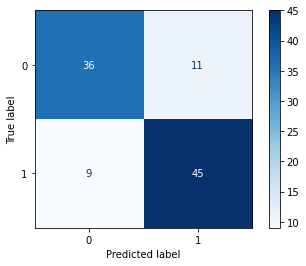

In [11]:
# Run a random forest classifier and observe the results
random_forest_clf = run_random_forest(X, y)

In [12]:
import pickle

pickle.dump(random_forest_clf, open("random_forest_clf", 'wb'))

In [13]:
import pickle

random_forest_clf = pickle.load(open("random_forest_clf", 'rb'))

# Part 2: Diarization

In order to classify social contingency, we must be able to distinguish between speaking individuals, as well as when there is silence or extra noise. This part will demonstrate how diarization is approached for this project

## 2A. Create partial embeddings for each audio segment
#### Embeddings are created using Resemblyzer's VoiceEncoder. For more info and for the repo, check out [Resemblyzer](https://github.com/resemble-ai/Resemblyzer)

An example follows, using an interview from the dataset

In [6]:
from speaker_diarization import *

In [8]:
import librosa
wav_file = "/content/drive/MyDrive/Maciej_Zielonka_Senior_Project/Interview_data/P5_S1.wav"
y, sr = librosa.load(wav_file)

In [9]:
embeddings, wav_splits = generate_embeddings(y)

Loaded the voice encoder model on cpu in 0.01 seconds.


## 2B. Cluster the embeddings

#### For this project, [scikit learn's spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) was used to cluster the embeddings

In [10]:
labels = spectral_cluster_predict(embeddings, n_clusters=3)

[0 1 2]


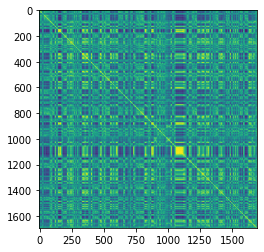

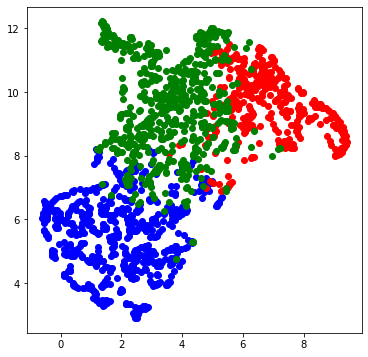

In [11]:
# Visualize the embeddings:

show_plots(embeddings, labels)

## 2C. Create the labellings for the wav segment

In [12]:
diarization_dict, labelling = label_wav_splits(y, wav_splits, labels)

In [13]:
print_diarization(labelling)

0:0.0 - 0:5.5 -- Adult
0:5.5 - 0:6.4 -- Silence
0:6.4 - 0:6.6 -- Child
0:6.6 - 0:15.8 -- Adult
0:15.8 - 0:16.2 -- Child
0:16.2 - 0:16.7 -- Silence
0:16.7 - 0:17.5 -- Adult
0:17.5 - 0:19.3 -- Child
0:19.3 - 0:22.5 -- Adult
0:22.5 - 0:23.1 -- Child
0:23.1 - 0:24.2 -- Silence
0:24.2 - 0:25.1 -- Child
0:25.1 - 0:26.7 -- Adult
0:26.7 - 0:27.4 -- Child
0:27.4 - 0:32.1 -- Silence
0:32.1 - 0:34.7 -- Child
0:34.7 - 0:39.9 -- Adult
0:39.9 - 0:44.7 -- Child
0:44.7 - 0:45.4 -- Silence
0:45.4 - 0:46.7 -- Child
0:46.7 - 0:46.8 -- Silence
0:46.8 - 0:47.6 -- Child
0:47.6 - 0:47.7 -- Adult
0:47.7 - 0:50.1 -- Child
0:50.1 - 0:51.9 -- Adult
0:51.9 - 0:52.3 -- Child
0:52.3 - 0:52.6 -- Silence
0:52.6 - 0:54.5 -- Adult
0:54.5 - 0:55.5 -- Silence
0:55.5 - 0:56.1 -- Child
0:56.1 - 0:57.7 -- Adult
0:57.7 - 0:57.9 -- Child
0:57.9 - 1:0.8 -- Adult
1:0.8 - 1:3.5 -- Silence
1:3.5 - 1:3.7 -- Child
1:3.7 - 1:4.1 -- Silence
1:4.1 - 1:4.4 -- Child
1:4.4 - 1:4.8 -- Silence
1:4.8 - 1:8.4 -- Child
1:8.4 - 1:9.5 -- Silenc

##### The above technique creates partial embeddings for the entire interview, then clusters the embeddings into three segments: Adult, Child, and Silent. But it might be better to try to embed the speakers alone, and take out the silence initially. Here, [pydub's silence library](https://https://github.com/jiaaro/pydub/blob/master/pydub/silence.py) was used to initially extract all the speech, without any of the silence, and just create the clusters: Adult, Child

Loaded the voice encoder model on cpu in 0.03 seconds.
[0 1]


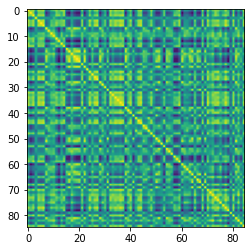

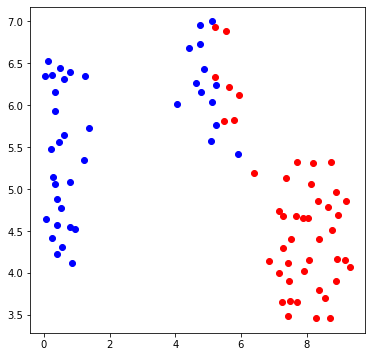

In [27]:
labelling, silent_segments = diarize_with_pydub(wav_file, 500, -50)

##### We see the embeddings are much more distinct, and although the final diarization is similar to the original, non-pydub using one, there is less noise splitting up the two. It is up to the user to decide which technique to use.

In [15]:
print_diarization(labelling)

0:0.0 - 0:3.1 -- Adult
0:3.1 - 0:3.6 -- Silence
0:3.6 - 0:5.3 -- Adult
0:5.3 - 0:6.4 -- Silence
0:6.4 - 0:16.0 -- Adult
0:16.0 - 0:16.7 -- Silence
0:16.7 - 0:17.3 -- Child
0:17.3 - 0:17.9 -- Silence
0:17.9 - 0:23.0 -- Adult
0:23.0 - 0:24.1 -- Silence
0:24.1 - 0:26.8 -- Adult
0:26.8 - 0:32.2 -- Silence
0:32.2 - 0:39.9 -- Adult
0:39.9 - 0:40.7 -- Silence
0:40.7 - 0:41.1 -- Child
0:41.1 - 0:41.7 -- Silence
0:41.7 - 0:42.5 -- Child
0:42.5 - 0:43.1 -- Silence
0:43.1 - 0:44.6 -- Adult
0:44.6 - 0:45.4 -- Silence
0:45.4 - 0:49.5 -- Child
0:49.5 - 0:50.0 -- Silence
0:50.0 - 0:52.3 -- Adult
0:52.3 - 0:53.0 -- Silence
0:53.0 - 0:54.2 -- Adult
0:54.2 - 0:55.0 -- Silence
0:55.0 - 0:57.0 -- Adult
0:57.0 - 0:57.6 -- Silence
0:57.6 - 1:0.6 -- Adult
1:0.6 - 1:1.3 -- Silence
1:1.3 - 1:2.7 -- Child
1:2.7 - 1:3.8 -- Silence
1:3.8 - 1:3.9 -- Child
1:3.9 - 1:4.6 -- Silence
1:4.6 - 1:6.2 -- Child
1:6.2 - 1:6.7 -- Silence
1:6.7 - 1:7.2 -- Child
1:7.2 - 1:7.8 -- Silence
1:7.8 - 1:8.0 -- Child
1:8.0 - 1:9.1 -- 

# Part 3: Determine Social Contingency of an Interaction


## 3A. Extract Structural Features From the Data

#### When determining social contingency, we will be looking at silence within the conversation, how often each agent speaks in the conversation, and the engagement present in the responses. So let's extract that information



In [13]:
from structural_feature_extractors import *

In [ ]:
silent_periods, silent_period_lengths, engagement_tracker = extract_structural_features_from_diarized_interview(y, labelling, random_forest_clf)

[[0.00040909]]


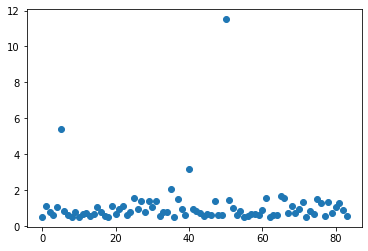

array([0.00040909])

In [18]:
# How much does the duration of silence change?

find_silence_slope(silent_period_lengths)

Here we'll extract structural features that may indicate the presence, or the lack of social contingency in a conversation. 

In [15]:
import pandas as pd

def analyze_contingency(silent_periods, silent_period_lengths, engagement_tracker, sr=22050):
    attributes = {}
    sum_silence = sum(silent_period_lengths)
    avg_silence = np.mean(silent_period_lengths)
    std_silence = np.std(silent_period_lengths)
    attributes['Avg Silence'] = avg_silence/sr
    attributes['Std Silence'] = std_silence/sr
    slope = find_silence_slope(silent_period_lengths)
    attributes['Silence Slope'] = slope 
    num_engaged = sum([1 for i in engagement_tracker if i == 1])
    num_disengaged = sum([1 for i in engagement_tracker if i == 0])
    num_no_answer = sum([1 for i in engagement_tracker if i == -1])
    attributes['Engaged'] = num_engaged
    attributes['Disengaged'] = num_disengaged
    attributes['No Answers'] = num_no_answer
    df = pd.DataFrame(attributes, index=[1])
    return df


[[0.00040909]]


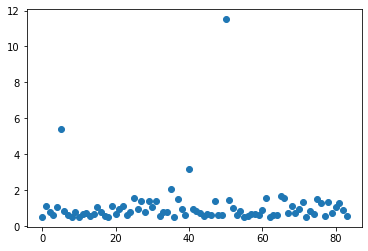

In [20]:
contingency_df = analyze_contingency(silent_periods, silent_period_lengths, engagement_tracker)

In [21]:
contingency_df

,Avg Silence,Std Silence,Silence Slope,Engaged,Disengaged,No Answers
1,1.087678,1.315407,0.000409,0,40,26


# Putting It All Together


This section contains a runnable example of everything above. Just load the model, pick the audio file you want to analyze, and run

In [7]:
import librosa
def extract_social_contingency_df_for_wav(audio_path, clf):
    print(audio_path)
    y, sr = librosa.load(audio_path)
    labelling = diarize_with_pydub(audio_path, 500)[0]
    print_diarization(labelling)
    silent_periods, silent_period_lengths, engagement_tracker = extract_structural_features_from_diarized_interview(y, labelling, clf)
    return analyze_contingency(silent_periods, silent_period_lengths, engagement_tracker, sr)

In [11]:
import os

all_interviews = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir)]

In [ ]:
import pickle

random_forest_clf = pickle.load(open("random_forest_clf", 'rb'))

/content/drive/MyDrive/Maciej_Zielonka_Senior_Project/Interview_data/P44_S2.wav
Loaded the voice encoder model on cpu in 0.02 seconds.
[0 1]


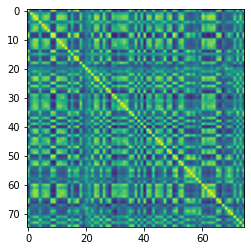

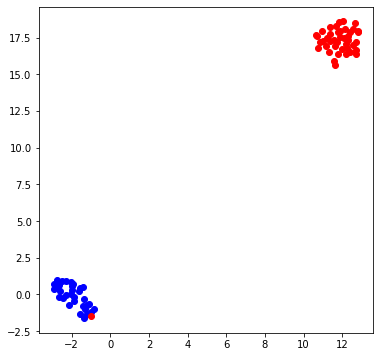

0:0.0 - 0:0.4 -- Adult
0:0.4 - 0:3.0 -- Silence
0:3.0 - 0:4.6 -- Child
0:4.6 - 0:6.6 -- Silence
0:6.6 - 0:12.6 -- Child
0:12.6 - 0:13.4 -- Silence
0:13.4 - 0:16.8 -- Child
0:16.8 - 0:19.2 -- Silence
0:19.2 - 0:19.7 -- Adult
0:19.7 - 0:20.5 -- Silence
0:20.5 - 0:21.4 -- Child
0:21.4 - 0:22.7 -- Silence
0:22.7 - 0:25.2 -- Child
0:25.2 - 0:39.0 -- Silence
0:39.0 - 0:41.3 -- Child
0:41.3 - 0:45.9 -- Silence
0:45.9 - 0:45.9 -- Adult
0:45.9 - 0:46.7 -- Silence
0:46.7 - 0:46.7 -- Adult
0:46.7 - 0:48.0 -- Silence
0:48.0 - 0:50.9 -- Child
0:50.9 - 0:54.1 -- Silence
0:54.1 - 0:58.1 -- Child
0:58.1 - 1:4.7 -- Silence
1:4.7 - 1:7.9 -- Child
1:7.9 - 1:9.3 -- Silence
1:9.3 - 1:10.6 -- Child
1:10.6 - 1:14.1 -- Silence
1:14.1 - 1:14.1 -- Adult
1:14.1 - 1:14.9 -- Silence
1:14.9 - 1:15.4 -- Child
1:15.4 - 1:16.6 -- Silence
1:16.6 - 1:17.1 -- Adult
1:17.1 - 1:17.8 -- Silence
1:17.8 - 1:18.0 -- Adult
1:18.0 - 1:19.0 -- Silence
1:19.0 - 1:20.4 -- Child
1:20.4 - 1:24.3 -- Silence
1:24.3 - 1:25.3 -- Child
1:

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=568
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=669
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=335
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=882
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=785
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1011
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core

[[-0.0041056]]


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=539
  n_fft, y.shape[-1]


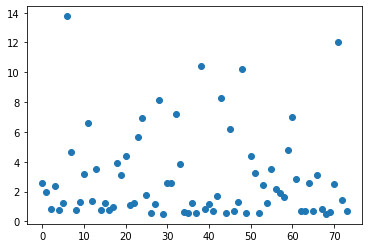

In [16]:
audio_path = all_interviews[8]
df = extract_social_contingency_df_for_wav(audio_path, random_forest_clf)

In [17]:
df

,Avg Silence,Std Silence,Silence Slope,Engaged,Disengaged,No Answers
1,2.857946,2.906865,-0.004106,34,9,11
